## 1D Model

In [368]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP,SaasPyroModel
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

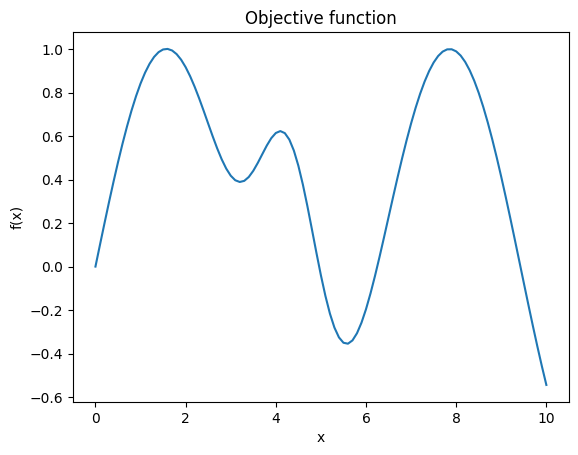

In [355]:
def F(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(y)

x = np.linspace(0,10,101)
y = F(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective function")
plt.show()

## Retrive initial dataset

(tensor([[6.4067],
         [6.8719],
         [1.7555],
         [9.0433],
         [4.4848]]),
 tensor([[0.1410],
         [0.5573],
         [0.9853],
         [0.3723],
         [0.4754]]),
 0.9852979183197021)

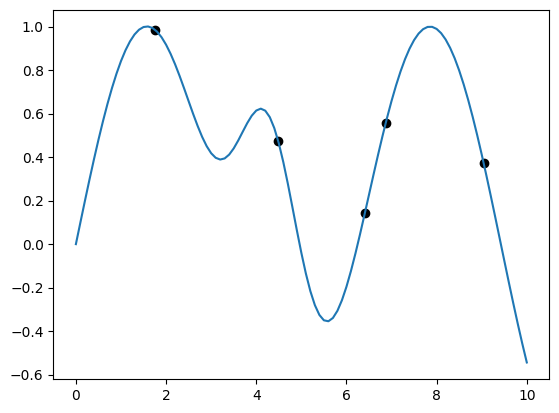

In [356]:
n = 5 # Number of training points
train_x = torch.rand(n,1)*10
train_y = F(train_x).unsqueeze(-1)
best_observed = train_y.max().item()
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(x,F(x))
plt.show
train_x,train_y,best_observed

## Fit GP model
Default:
    likelihood: standard Gaussian likelihood with inferred noise level
    Covar_module: Matern kernel
    Mean_module: Constant mean

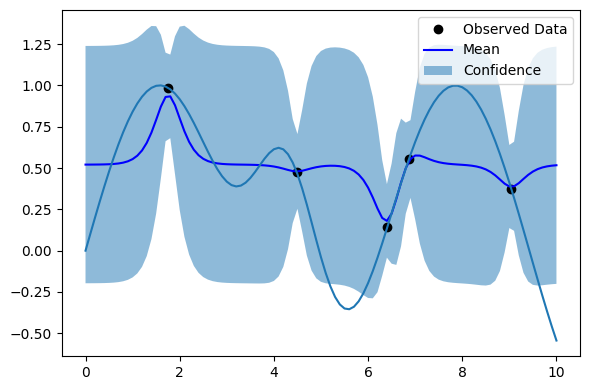

In [357]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

# Plot results
model.eval()

# Initialize plot
f,ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'ko')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Fully Bayesian GP Models (High dimensional problems)
Sample a set of hyperparameters from the posterior
Prior: sparse axis-aligned subspace priors (SAAS) model to identify the most important parameters

In [358]:
# saas_gp = SaasFullyBayesianSingleTaskGP(train_x, train_y)
# fit_fully_bayesian_model_nuts(saas_gp)
# posterior = saas_gp.posterior(test_x)

## Acquistion function
Morte-Carlo sampling:
1. Sampling joint posterior over q points
2. evaluate the current best for each sample
3. maximise over q
4. average over the samples

# EI Defaults:
1. Sampler: SobolQMCNormalSampler
2. Objective: IdentityMCObjective() (objective under which samples is evaluated)

In [365]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Noisy Expected Improvement:
Does not assume best_f, compute improvement over the previous points and average

In [372]:
NEI = qNoisyExpectedImprovement(
    model = model,
    X_baseline = train_x,
    prune_baseline= True,
)

## qUCB
beta: control the tradeoff between mean and variance.

In [373]:
UCB = qUpperConfidenceBound(
    model = model,
    beta = 0.6,
)

## Optimise acquisition function

In [370]:
candidates_x,_ = optimize_acqf(
    acq_function = UCB,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[ 5.6999],
         [ 7.4945],
         [ 2.7355],
         [ 8.2683],
         [ 3.3928],
         [ 2.0645],
         [ 5.0041],
         [ 1.4685],
         [ 1.0028],
         [10.0000]]),
 tensor([[-0.3394],
         [ 0.9361],
         [ 0.5248],
         [ 0.9154],
         [ 0.4101],
         [ 0.8907],
         [-0.0441],
         [ 0.9953],
         [ 0.8430],
         [-0.5440]]))

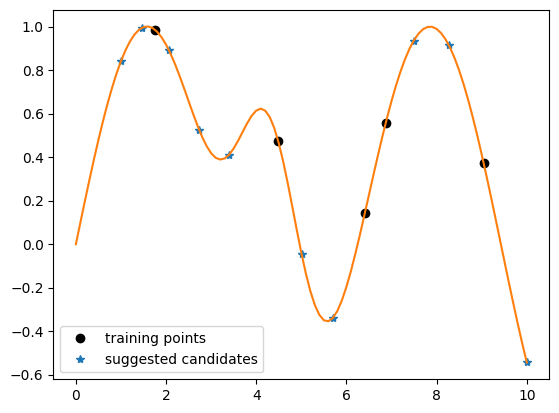

In [371]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

## Take in suggested data, forming new training dataset

In [363]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y

(tensor([[ 6.4067],
         [ 6.8719],
         [ 1.7555],
         [ 9.0433],
         [ 4.4848],
         [ 3.0129],
         [ 0.0000],
         [ 2.2207],
         [10.0000],
         [ 3.7196],
         [ 7.4568],
         [ 1.9507],
         [ 0.6774],
         [ 1.2498],
         [ 1.5577]]),
 tensor([[ 1.4097e-01],
         [ 5.5731e-01],
         [ 9.8530e-01],
         [ 3.7230e-01],
         [ 4.7543e-01],
         [ 4.1450e-01],
         [ 1.3995e-08],
         [ 8.1602e-01],
         [-5.4402e-01],
         [ 5.2464e-01],
         [ 9.2223e-01],
         [ 9.3473e-01],
         [ 6.2677e-01],
         [ 9.4906e-01],
         [ 1.0007e+00]]))

## Posterior model

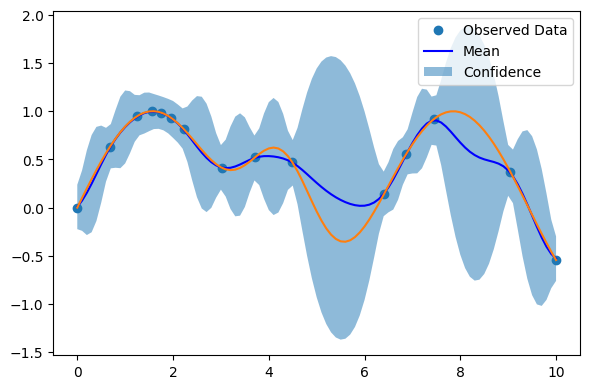

In [364]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Second run

In [335]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [336]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[0.6498],
         [8.3366],
         [7.8985],
         [2.3908],
         [9.1093],
         [7.2003],
         [1.7419],
         [3.3575],
         [4.1215],
         [1.2938]]),
 tensor([[0.6050],
         [0.8858],
         [0.9990],
         [0.7214],
         [0.3102],
         [0.7942],
         [0.9876],
         [0.4028],
         [0.6225],
         [0.9621]]))

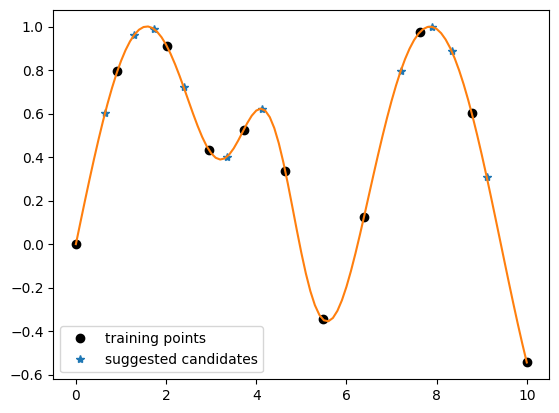

In [337]:
plt.plot(posterior_x,posterior_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

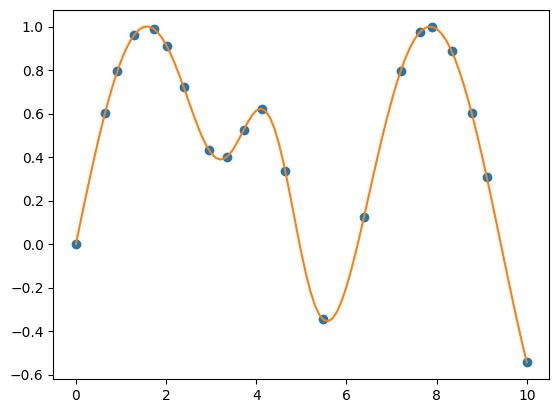

In [338]:
combine_x = (posterior_x,candidates_x)
combine_y = (posterior_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')
plt.plot(x,F(x))

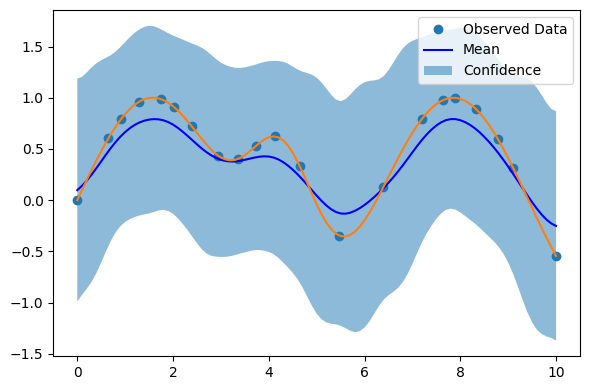

In [339]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()